# Attempt 1

In [ ]:
import tensorflow as tf
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

from flows import *

import os

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
def plot_density(data):
    x, y = np.squeeze(np.split(data, 2, axis=1))
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)

    xmin, xmax = min(x), max(x)
    ymin, ymax = min(y), max(y)

    # Peform the kernel density estimate
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    f = np.reshape(kernel(positions).T, xx.shape)
    
    # Plot the kernel density estimate
    plt.contourf(xx, yy, f, cmap='viridis')
    plt.gca().set_aspect('equal')

In [ ]:
N = 1000000
data = np.sin(stats.multivariate_normal.rvs([0, 0], [1, 1], size = N))
plot_density(data)

In [ ]:
target = flow(data)

In [ ]:
target_data = target.sample(N)

In [ ]:
plot_density(target_data)

In [ ]:
# Get probabilities
target.prob(target_data).numpy()

# Attempt 2

In [1]:
import numpy as np
import tqdm as tqdm
import sklearn.datasets as skd

# visualization
import matplotlib.pyplot as plt
from scipy.stats import kde

# tf and friends
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import sonnet as snt
tf.enable_v2_behavior()

tfb = tfp.bijectors
tfd = tfp.distributions

def make_grid(xmin, xmax, ymin, ymax, gridlines, pts):
    xpts = np.linspace(xmin, xmax, pts)
    ypts = np.linspace(ymin, ymax, pts)
    xgrid = np.linspace(xmin, xmax, gridlines)
    ygrid = np.linspace(ymin, ymax, gridlines)
    xlines = np.stack([a.ravel() for a in np.meshgrid(xpts, ygrid)])
    ylines = np.stack([a.ravel() for a in np.meshgrid(xgrid, ypts)])
    return np.concatenate([xlines, ylines], 1).T

grid = make_grid(-3, 3, -3, 3, 4, 100)

import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
base_distribution = tfd.MultivariateNormalDiag([0, 0], [1, 1])

2022-12-08 20:26:05.671257: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 20:26:06.283221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22824 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:81:00.0, compute capability: 7.5


In [4]:
class MLP_ODE(snt.Module):
    """Multi-layer NN ode_fn."""
    def __init__(self, num_hidden, num_layers, num_output, name='mlp_ode'):
        super(MLP_ODE, self).__init__(name=name)
        self._num_hidden = num_hidden
        self._num_output = num_output
        self._num_layers = num_layers
        self._modules = []
        for _ in range(self._num_layers - 1):
            self._modules.append(snt.Linear(self._num_hidden))
            self._modules.append(tf.math.tanh)
        self._modules.append(snt.Linear(self._num_output))
        self._model = snt.Sequential(self._modules)

    def __call__(self, t, inputs):
        inputs = tf.concat([tf.broadcast_to(t, inputs.shape), inputs], -1)
        return self._model(inputs)

In [5]:
LR = 1e-2 
NUM_EPOCHS = 80 
STACKED_FFJORDS = 4 
NUM_HIDDEN = 8 
NUM_LAYERS = 3 
NUM_OUTPUT = 2

In [6]:
solver = tfp.math.ode.DormandPrince(atol=1e-5)
ode_solve_fn = solver.solve
trace_augmentation_fn = tfb.ffjord.trace_jacobian_exact

bijectors = []
for _ in range(STACKED_FFJORDS):
    mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT)
    next_ffjord = tfb.FFJORD(
        state_time_derivative_fn=mlp_model,ode_solve_fn=ode_solve_fn,
        trace_augmentation_fn=trace_augmentation_fn)
    bijectors.append(next_ffjord)

stacked_ffjord = tfb.Chain(bijectors[::-1])

In [7]:
transformed_distribution = tfd.TransformedDistribution(
    distribution=base_distribution, bijector=stacked_ffjord)

In [8]:
@tf.function
def train_step(optimizer, target_sample):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(transformed_distribution.log_prob(target_sample))
    variables = tape.watched_variables()
    gradients = tape.gradient(loss, variables)
    optimizer.apply(gradients, variables)
    return loss

In [9]:
mc = np.load("../data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")

sim_pt =  mc['sim_jets'][:, 0]
sim_eta = mc['sim_jets'][:, 1]
sim_phi = mc['sim_jets'][:, 2]
sim_m =   mc['sim_jets'][:, 3]

In [10]:
data = np.vstack([sim_pt, sim_eta]).T

In [11]:
N = data.shape[0]
BATCH_SIZE = 256

In [12]:
dataset = tf.data.Dataset.from_tensor_slices(data.astype(np.float32)) \
            .prefetch(tf.data.experimental.AUTOTUNE) \
            .cache() \
            .shuffle(N) \
            .batch(BATCH_SIZE)

In [13]:
learning_rate = tf.Variable(LR, trainable=False)
optimizer = snt.optimizers.Adam(learning_rate)

for epoch in tqdm.trange(NUM_EPOCHS // 2):
    for batch in dataset:
        _ = train_step(optimizer, batch)

  0%|          | 0/40 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


100%|██████████| 40/40 [8:36:20<00:00, 774.52s/it]   


In [14]:
N = data.shape[0]
sample = transformed_distribution.sample(N)

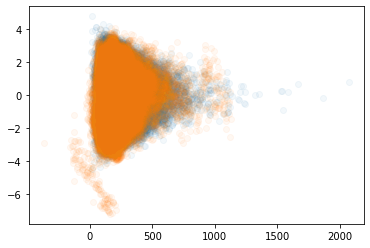

In [15]:
plt.scatter(data[:, 0], data[:, 1], alpha = 0.05)
plt.scatter(sample[:, 0], sample[:, 1], alpha = 0.05)